# EDA Profundo y Feature Engineering (Sprint 3)

# Paso 0: Instalación de requerimientos y conexión con GoogleCloud.

In [1]:
!sudo apt-get install python3.7
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.1


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.7 is already the newest version (3.7.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Libreria para conectarse a BigQuery desde Python
from google.cloud import bigquery

# id del proyecto en Google Cloud
project_id = 'driven-atrium-445021-m2'

# Creación del cliente BigQuery
bq_client = bigquery.Client(project = project_id)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Paso 1: Carga de datos, creación y unión de las tablas.

In [5]:
trips_query_job = bq_client.query('''SELECT pickup_year,
                                      pickup_month,
                                      pickup_day_of_month,
                                      pickup_day_of_week,
                                      pickup_hour_of_day,
                                      pickup_location_id,
                                      COUNT(trip_id) AS total_trips,
                                FROM `driven-atrium-445021-m2.project_data.trips`
                                WHERE pickup_year > 2023 AND pickup_month > 4
                                GROUP BY
                                      pickup_year ,
                                      pickup_month,
                                      pickup_day_of_month ,
                                      pickup_day_of_week,
                                      pickup_hour_of_day,
                                      pickup_location_id
                                ORDER BY
                                      pickup_year,
                                      pickup_month,
                                      pickup_day_of_month,
                                      pickup_hour_of_day,
                                      pickup_location_id''')

bq_trip_counts = trips_query_job.result().to_dataframe()

# el simbolo ~ es para indicar complemento, aqui lo que se hace es tomar todos los valores de location_id MENOS el 264 y 265
# El mapa solo mostrara los location_id que van del 1 al 263, por eso se eliminan 264 y 265 que corresponden a unknown y "outside of NYC"

bq_trip_counts = bq_trip_counts[~bq_trip_counts['pickup_location_id'].isin([264,265])].copy().reset_index(drop=True)
print(bq_trip_counts.shape)
bq_trip_counts.head(2)

(1117218, 7)


,pickup_year,pickup_month,pickup_day_of_month,pickup_day_of_week,pickup_hour_of_day,pickup_location_id,total_trips
0,2024,5,1,2,0,3,19
1,2024,5,1,2,0,4,54


In [6]:
bq_trip_counts.tail(2)

,pickup_year,pickup_month,pickup_day_of_month,pickup_day_of_week,pickup_hour_of_day,pickup_location_id,total_trips
1117216,2024,10,31,3,23,262,132
1117217,2024,10,31,3,23,263,348


## Para este análisis que se esta realizando acá, la data de los viajes va desde el 01/05/2024 hasta el 31/10/2024 (6 meses), lo cual se tomara en cuenta para el clima también.

In [7]:
weather_query_job = bq_client.query('''SELECT location_id, year, month, day_of_month, hour_of_day, day_of_week, temperature, relative_humidity, dew_point, apparent_temperature, weather_code, pressure_msl, cloud_cover, wind_speed, wind_direction, wind_gusts
                                        FROM `driven-atrium-445021-m2.project_data.weather`
                                        WHERE year > 2023 AND month > 4''')
clima = weather_query_job.result().to_dataframe()
print(clima.shape)
clima.head(2)

(22080, 16)


,location_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,1,2024,7,1,18,0,25.1,46.0,12.7,23.5,0.0,1017.4,6.0,17.0,354.0,38.5
1,2,2024,7,1,9,0,22.9,58.0,14.1,20.7,0.0,1016.1,14.0,24.7,347.0,44.6


## Se observa que la data de clima tiene 22.080 filas, que corresponden a todas las condiciones del clima, en todas las horas (24 h), desde el 01/05/2024 hasta el 31/10/2024 (184 días) en las 5 ubicaciones consultadas (5 boroughs).

In [8]:
clima.rename(columns={'location_id':'borough_id'}, inplace=True)
clima.head(2)

,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,1,2024,7,1,18,0,25.1,46.0,12.7,23.5,0.0,1017.4,6.0,17.0,354.0,38.5
1,2,2024,7,1,9,0,22.9,58.0,14.1,20.7,0.0,1016.1,14.0,24.7,347.0,44.6


## Se hace el cambio porque este location_id **NO** representa lo mismo que la columna con el mismo nombre en la tabla de viajes.<br><br>Tambien este cambio de nombre facilitará el merge que se hará mas adelante.

In [9]:
boroughs_query_job = bq_client.query('''SELECT location_id,
                                              zone,
                                              borough,
                                        FROM `driven-atrium-445021-m2.project_data.coordinates`''')
boroughs = boroughs_query_job.result().to_dataframe()

# el locationID 1 es un borough unico, y el mas cercano es Manhattan, por lo que por simplicidad se le asignó ese borough.

id_boroughs = {'Queens':1,'Brooklyn':2,'Manhattan':3,'Bronx':4,'Staten Island':5, 'EWR':3}
boroughs['borough_id'] = boroughs['borough'].map(id_boroughs)\
                                            .convert_dtypes(convert_integer=True)

print(boroughs.shape)
boroughs.head(2)

(263, 4)


,location_id,zone,borough,borough_id
0,1,Newark Airport,EWR,3
1,3,Allerton/Pelham Gardens,Bronx,4


## Esta tabla tiene 263 filas, correspondiente a las 263 zonas que hay en Nueva York de acuardo al TLC NYC (ente regulador de taxis).

In [10]:
# Merge para crear tabla base que contiene todas las condiciones climaticas en todas las 263 zonas a TODAS las horas.
# Esto permitira hacer el JOIN con viajes y capturar los valores nulos que representan valores de cero viajes.
clima_borough_merge = boroughs.merge(clima,how='left', on='borough_id')

print(clima_borough_merge.shape)
clima_borough_merge.head(2)

(1161408, 19)


,location_id,zone,borough,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,1,Newark Airport,EWR,3,2024,7,1,22,0,21.2,51.0,10.6,19.0,0.0,1020.9,7.0,16.7,14.0,28.8
1,1,Newark Airport,EWR,3,2024,7,1,7,0,20.0,68.0,13.9,18.3,0.0,1015.2,18.0,20.3,343.0,37.8


## El dataset contiene 1.161.408 registros, correspondientes a todas las horas (4416) por cada zona de Nueva York (263).

## A continuación se cambiarán los nombres de las columnas en la tabla de viajes para hacer el merge con clima_boroughs.

In [11]:
# Cambiando los nombres de las columnas en la tabla de viajes para hacer el merge con clima_boroughs.

bq_trip_counts.rename(columns={'pickup_year':'year',
                               'pickup_month':'month',
                               'pickup_day_of_month':'day_of_month',
                               'pickup_hour_of_day':'hour_of_day',
                               'pickup_location_id':'location_id',
                               'pickup_day_of_week':'day_of_week'}, inplace=True)

bq_trip_counts.head(3)

,year,month,day_of_month,day_of_week,hour_of_day,location_id,total_trips
0,2024,5,1,2,0,3,19
1,2024,5,1,2,0,4,54
2,2024,5,1,2,0,5,3


In [12]:
ML_merge = clima_borough_merge.merge(bq_trip_counts,
                                     how='left',
                                     on=['location_id',
                                         'year',
                                         'month',
                                         'day_of_month',
                                         'day_of_week',
                                         'hour_of_day'])

print(ML_merge.shape)
ML_merge.head(2)

(1161408, 20)


,location_id,zone,borough,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts,total_trips
0,1,Newark Airport,EWR,3,2024,7,1,22,0,21.2,51.0,10.6,19.0,0.0,1020.9,7.0,16.7,14.0,28.8,2
1,1,Newark Airport,EWR,3,2024,7,1,7,0,20.0,68.0,13.9,18.3,0.0,1015.2,18.0,20.3,343.0,37.8,2


In [13]:
ML_merge.isna().sum()

,0
location_id,0
zone,0
borough,0
borough_id,0
year,0
month,0
day_of_month,0
hour_of_day,0
day_of_week,0
temperature,0


## Aquí podemos observar que luego de este merge entre las tablas hay **44190** valores nulos. <br><br> Al contar el numero de viajes por location_id, aquellas zonas que tienen 0 viajes a determinadas horas no se registran en las tablas.<br><br> El modo como se diseñaron las tablas en este notebook permite registrar esos valores que son necesarios para un correcto entrenamiento del modelo ML. A continuación se procederá a sustituir estos valores nulos.

In [14]:
ML_merge.fillna(0,inplace=True)
ML_merge['total_trips'].isna().sum()

0

# Paso 2: Graficos y Correlaciones

## Terminada la carga y unión de tablas, y la correspondiente imputación de valores nulos explicada anteriormente, se procede a mostrar los graficos pertinentes.<br><br> Primero los viajes

In [15]:
# Conteo de viajes SIN SEPARAR por location_id, para realizar el análisis con todos los viajes en conjunto.

trip_counts = bq_trip_counts.groupby(['year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day'])\
                                .agg(Count=('hour_of_day','count'))\
                                .reset_index()

trip_counts.head(3)

,year,month,day_of_month,day_of_week,hour_of_day,Count
0,2024,5,1,2,0,245
1,2024,5,1,2,1,243
2,2024,5,1,2,2,245


In [16]:
bq_trip_counts.shape

(1117218, 7)

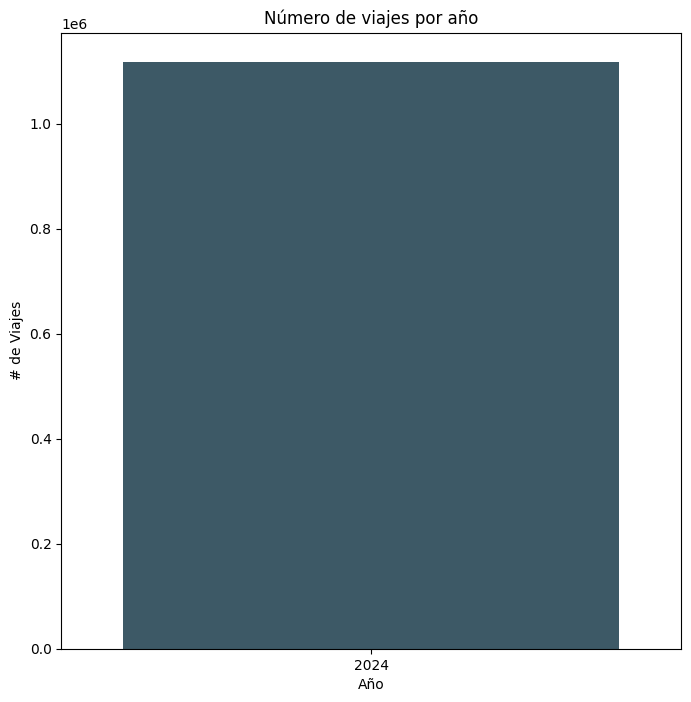

In [17]:
plt.figure(figsize=(8,8))
sns.countplot(data=bq_trip_counts,x='year',order=[2024],color='#365B6D')
plt.title('Número de viajes por año')
plt.xlabel('Año')
plt.ylabel('# de Viajes')
plt.show()

## Acá podemos tenemos el total de viajes de la muestra tomada para este EDA-FE (1.117.218)

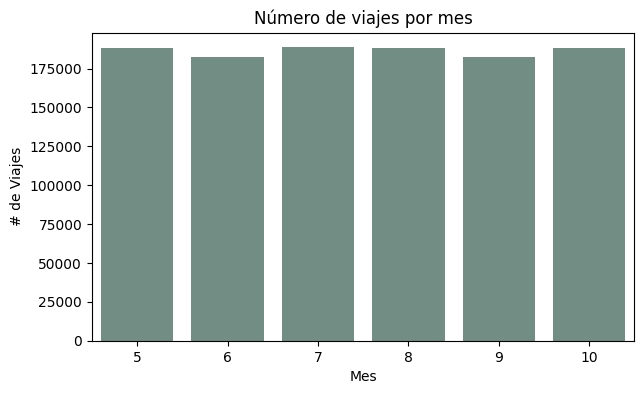

In [18]:
plt.figure(figsize=(7,4))
sns.countplot(data=bq_trip_counts,x='month', color='#6C9286')
plt.title('Número de viajes por mes')
plt.xlabel('Mes')
plt.ylabel('# de Viajes')
plt.show()

## Se observa que todos los valores se encuentran alrededor de 175000 viajes por mes.<br><br>Las diferencias entre meses se deben al numero de días que tiene cada mes. Es por ello que los meses que tienen 31 días están por encima de los meses con 30 días.



In [19]:
promedio_diario=trip_counts.drop(columns=['month','day_of_week'])\
                           .groupby(by=['day_of_month'], as_index=False)\
                           .mean()
promedio_diario.head(2)

,day_of_month,year,hour_of_day,Count
0,1,2024.0,11.5,252.9375
1,2,2024.0,11.5,252.979167


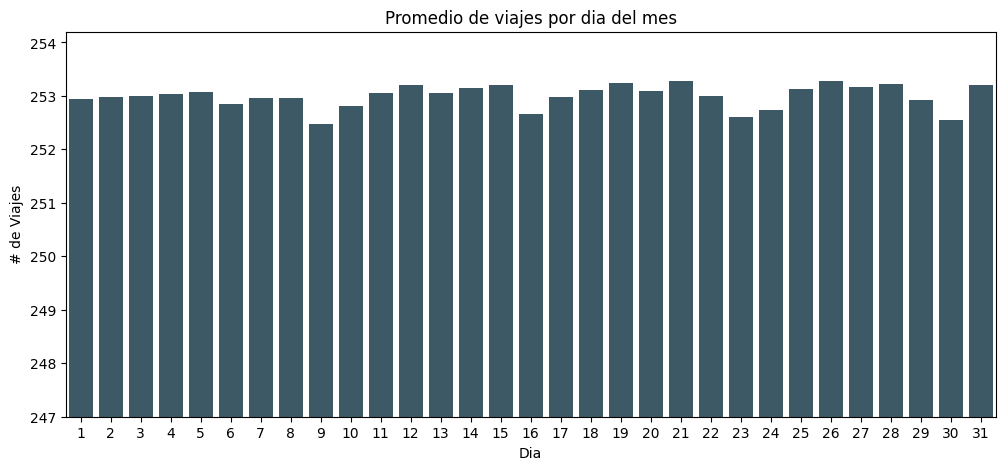

In [20]:
plt.figure(figsize=(12,5))
sns.barplot(data=promedio_diario, x='day_of_month', y='Count',color='#365B6D')
plt.title('Promedio de viajes por dia del mes')
plt.xlabel('Dia')
plt.ylabel('# de Viajes')
plt.ylim(247,254.2)
plt.yticks(np.arange(247,255, step=1))
plt.show()

## Aquí se observa que el promedio de viajes por dia está alrededor de 253 y se observa cierta regularidad, donde comienza a crecer unos dias y luego una caida, que luego vuelve a comenzar a subir paulatinamente. Los valores mas bajos son 9, 16, 23 y 30, que tienen 7 dias entre si, por lo que quizas se deba al ciclo de los días de la semana (Lun-Dom).

In [21]:
promedio_dia_semana=trip_counts.drop(columns=['month'])\
                               .groupby(by=['day_of_week'],as_index=False)\
                               .mean()
promedio_dia_semana.head(2)

,day_of_week,year,day_of_month,hour_of_day,Count
0,0,2024.0,15.653846,11.5,252.483974
1,1,2024.0,15.5,11.5,252.219551


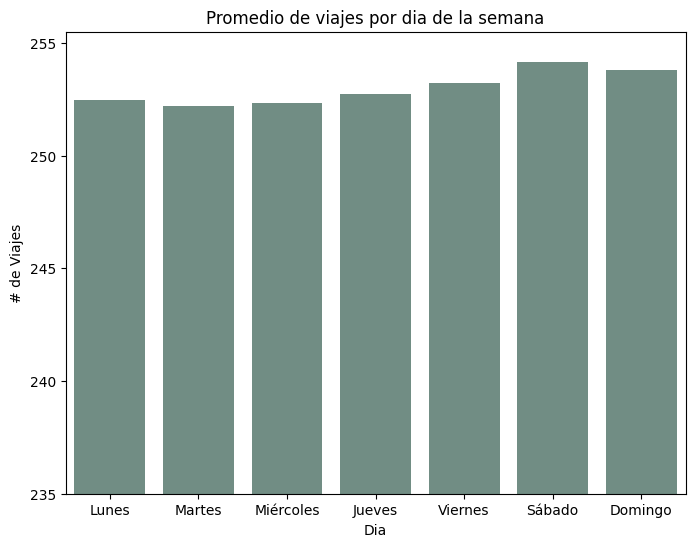

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(data=promedio_dia_semana, x='day_of_week', y='Count', color='#6C9286')
plt.title('Promedio de viajes por dia de la semana')
plt.xlabel('Dia')
plt.ylabel('# de Viajes')
plt.ylim(235,255.5)
plt.yticks(np.arange(235,256, step=5))
plt.xticks([0,1,2,3,4,5,6],['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
plt.show()

## Al evaluar por día de la semana, se ve que el promedio oscila entre 250 y 253 viajes por día, donde hay una mayor demanda hacia los fines de semana, en particular los sábados. Se observa cierta similaridad con la tendencia vista anteriormento respecto a los días del mes (1-31)

In [23]:
promedio_hora=trip_counts.drop(columns=['month']).groupby(by=['day_of_week','hour_of_day'],as_index=False).mean()

promedio_hora.head(2)

,day_of_week,hour_of_day,year,day_of_month,Count
0,0,0,2024.0,15.653846,252.307692
1,0,1,2024.0,15.653846,248.538462


In [24]:
weekday_name = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
promedio_hora['weekday_name'] = promedio_hora['day_of_week'].map(weekday_name)
promedio_hora.head(3)

,day_of_week,hour_of_day,year,day_of_month,Count,weekday_name
0,0,0,2024.0,15.653846,252.307692,Lunes
1,0,1,2024.0,15.653846,248.538462,Lunes
2,0,2,2024.0,15.653846,244.384615,Lunes


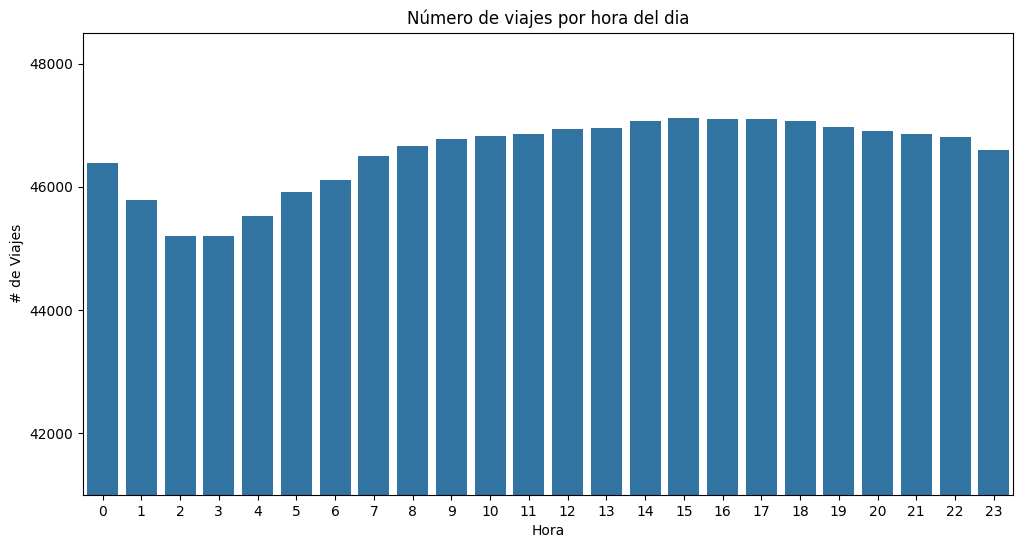

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(data=bq_trip_counts,x='hour_of_day')
plt.title('Número de viajes por hora del dia')
plt.xlabel('Hora')
plt.ylim(41000,48500)
plt.yticks(np.arange(42000,50000, step=2000))
plt.ylabel('# de Viajes')
plt.show()

## Acá se contabiliza el número de viajes de acuerdo a la hora del día, donde se ve la mayor variación desde horas de la madrugada donde esta el minimo de demanda, que aumenta rapido durante las primeras horas de la mañana hasta llegar a su máximo a mediados-finales de la tarde, para luego volver a descender hasta su mínimo durante la madrugada (2-3am).

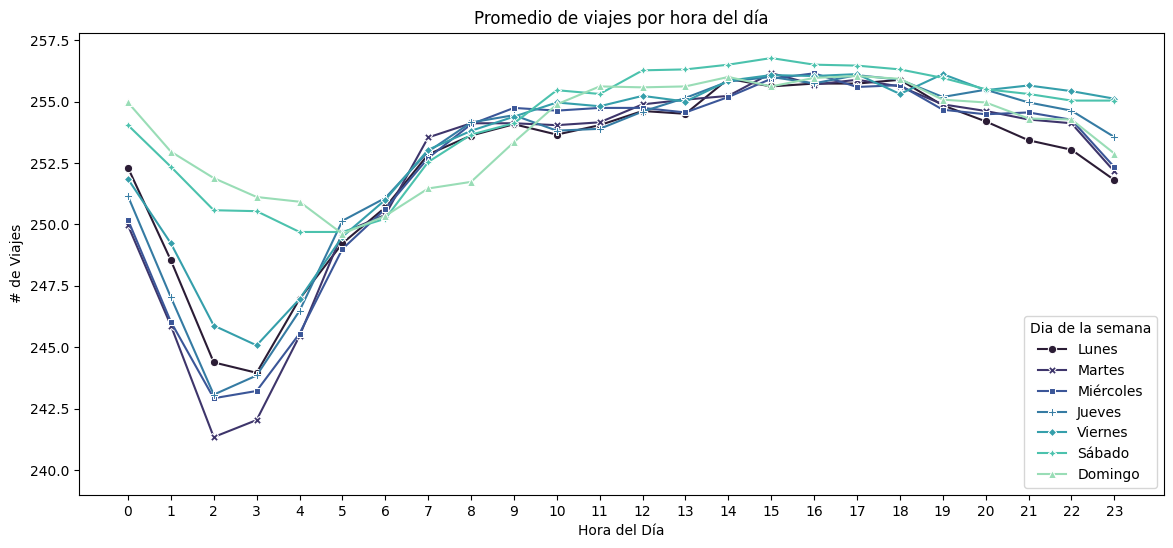

In [26]:
plt.figure(figsize=(14,6))
sns.lineplot(data=promedio_hora,
             x=promedio_hora['hour_of_day'],
             y=promedio_hora['Count'],
             hue=promedio_hora['weekday_name'],
             hue_order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'],
             errorbar=None,
             markers=True,
             palette='mako',
             style=promedio_hora['weekday_name'],
             dashes=False)

plt.title('Promedio de viajes por hora del día')
plt.xlabel('Hora del Día')
plt.ylabel('# de Viajes')
plt.legend(title='Dia de la semana')
plt.ylim(239,257.8)
plt.xticks(np.arange(0,24, step=1))
plt.show()

## Acá se grafica el promedio de viajes de acuerdo a la hora del día, separando por el día de la semana, donde se sigue observando la misma tendencia descrita anteriormente (minimo en la madrugada, máximo al final de la tarde), pero podemos notar que el comportamiento durante el día se puede separar en 2 grupos que muestran curvas diferentes: los días de la semana (Lun-Vie) vs. los fines de semana (Sáb-Dom).

In [27]:
location_sum = ML_merge.groupby(by=['location_id'],as_index=False).sum()
location_sum.shape

(263, 20)

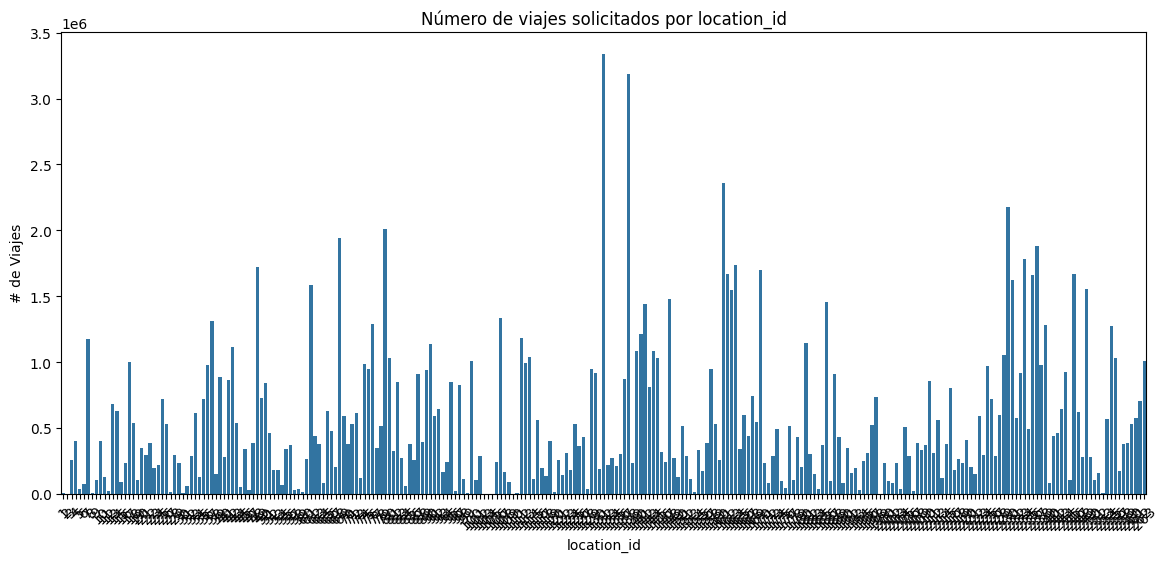

In [28]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum,x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por location_id')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.xticks(rotation=45)
plt.show()

## Acá observamos el conteo de viajes total en el período de tiempo estudiado separado por zonas, donde se observa grandes diferencias entre una zona y otra.<br><br>A continuación se mostrarán graficos con las zonas con mas viajes.

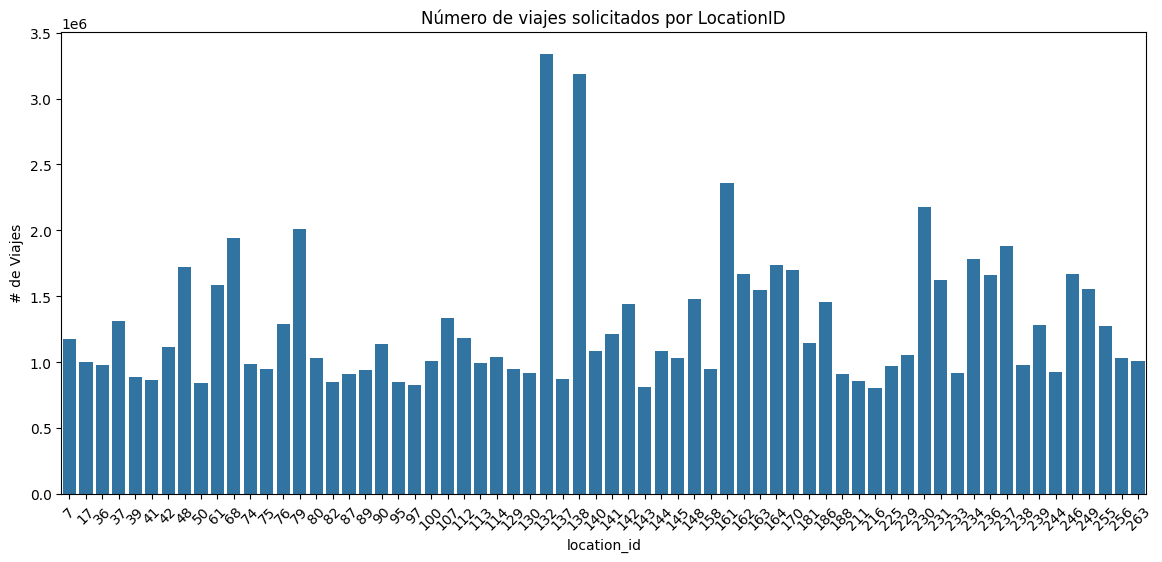

In [29]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum[location_sum['total_trips']>750000],x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por LocationID')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.xticks(rotation=45)
plt.show()

In [30]:
location_sum[location_sum['total_trips']>750000].shape

(66, 20)

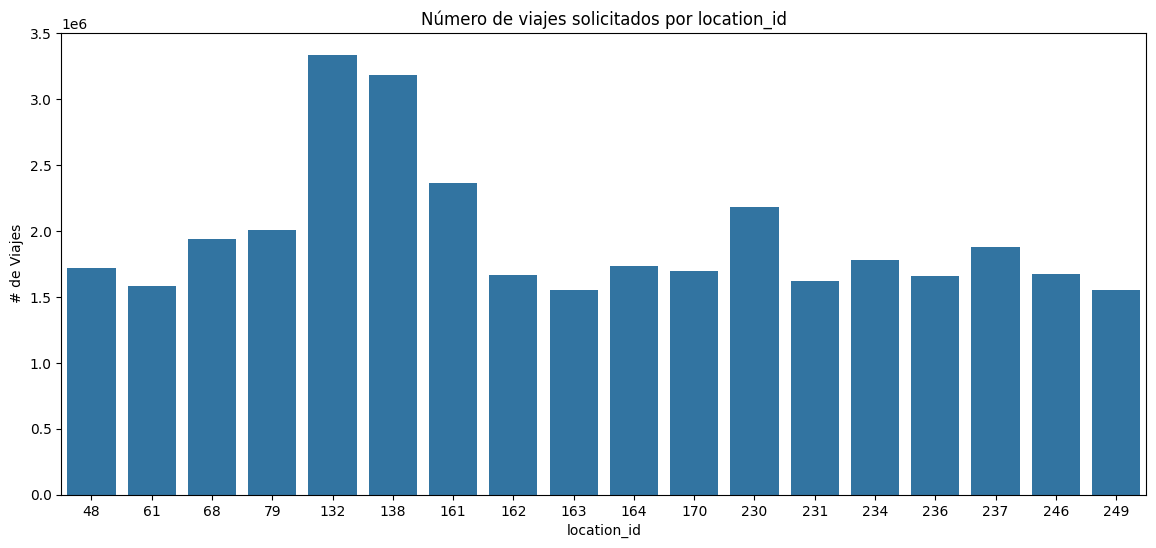

In [31]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum[location_sum['total_trips']>1500000],x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por location_id')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.show()

In [32]:
location_sum[location_sum['total_trips']>1500000].shape

(18, 20)

## En los 2 graficos anteriores se observa que, de todas las 263 zonas en el período de tiempo evaluado, 66 tienen más de 750.000 viajes y solo 18 acumulan más de 1.5M de viajes.

## A continuación mostraremos los mapas de correlaciones, que nos permitiran evaluar cuales columnas descartar para simplificar el entrenamiento del modelo de ML.

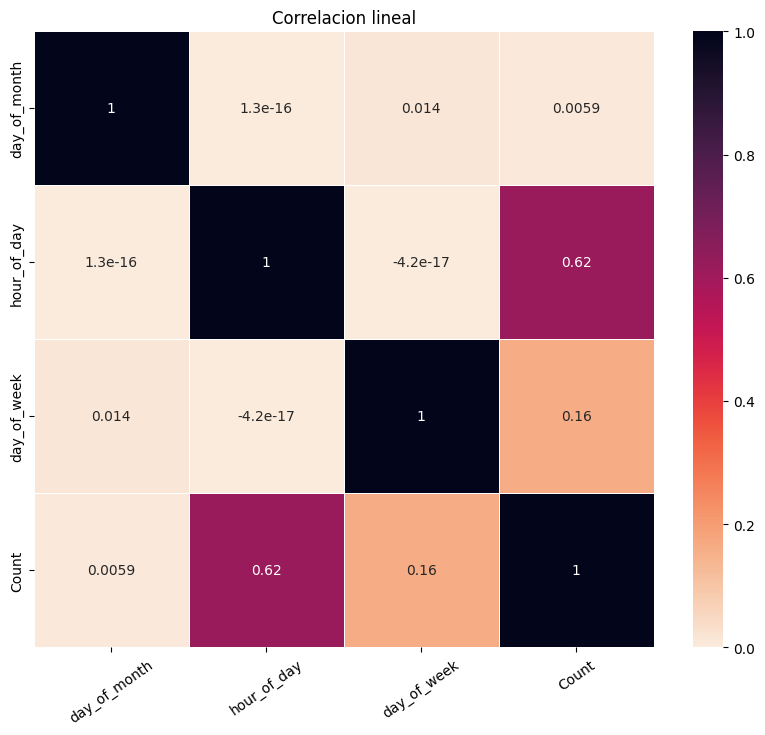

In [33]:
# Usando trip_counts que NO diferencia entre los locationID

time_corr = trip_counts[['day_of_month', 'hour_of_day','day_of_week', 'Count']].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(time_corr, annot=True, linewidth=.5,cmap='rocket_r')
plt.title('Correlacion lineal')
plt.xticks(rotation=35)
plt.show()

## Acá se muestra en un mapa de calor lo que los graficos también mostraron, que es que los atributos de hora del día y día de la semana son los que tienen mayor correlación con el numero de viajes.

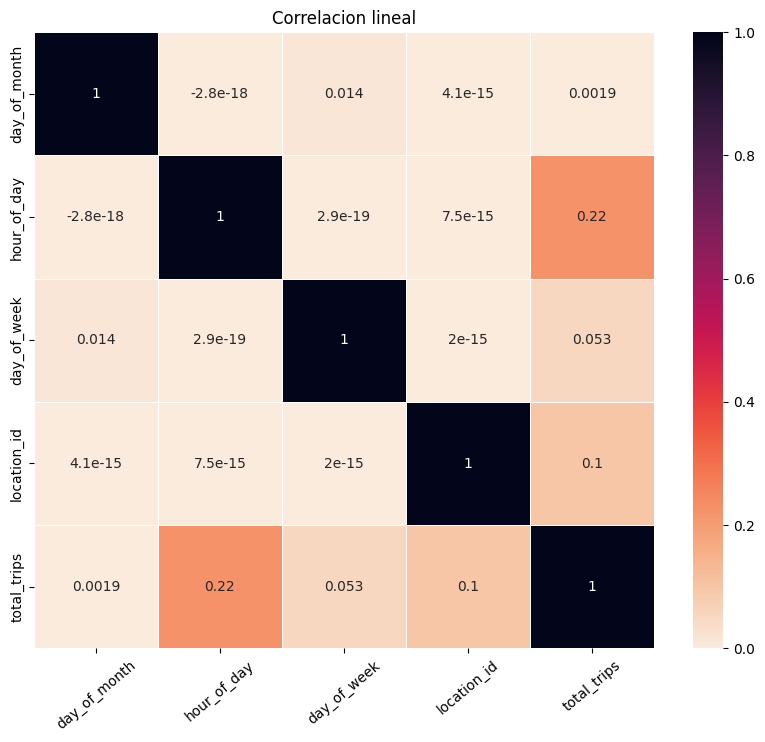

In [34]:
# Usando ML_merge que los separa por locationID y ademas considera los valores 0

time_location_corr = ML_merge[['day_of_month', 'hour_of_day', 'day_of_week','location_id', 'total_trips']].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(time_location_corr, annot=True, linewidth=.5,cmap='rocket_r')
plt.title('Correlacion lineal')
plt.xticks(rotation=40)
plt.show()

## Aquí se repite el análisis anterior, pero considerando las zonas, las cuales también influyen en el conteo de viajes.

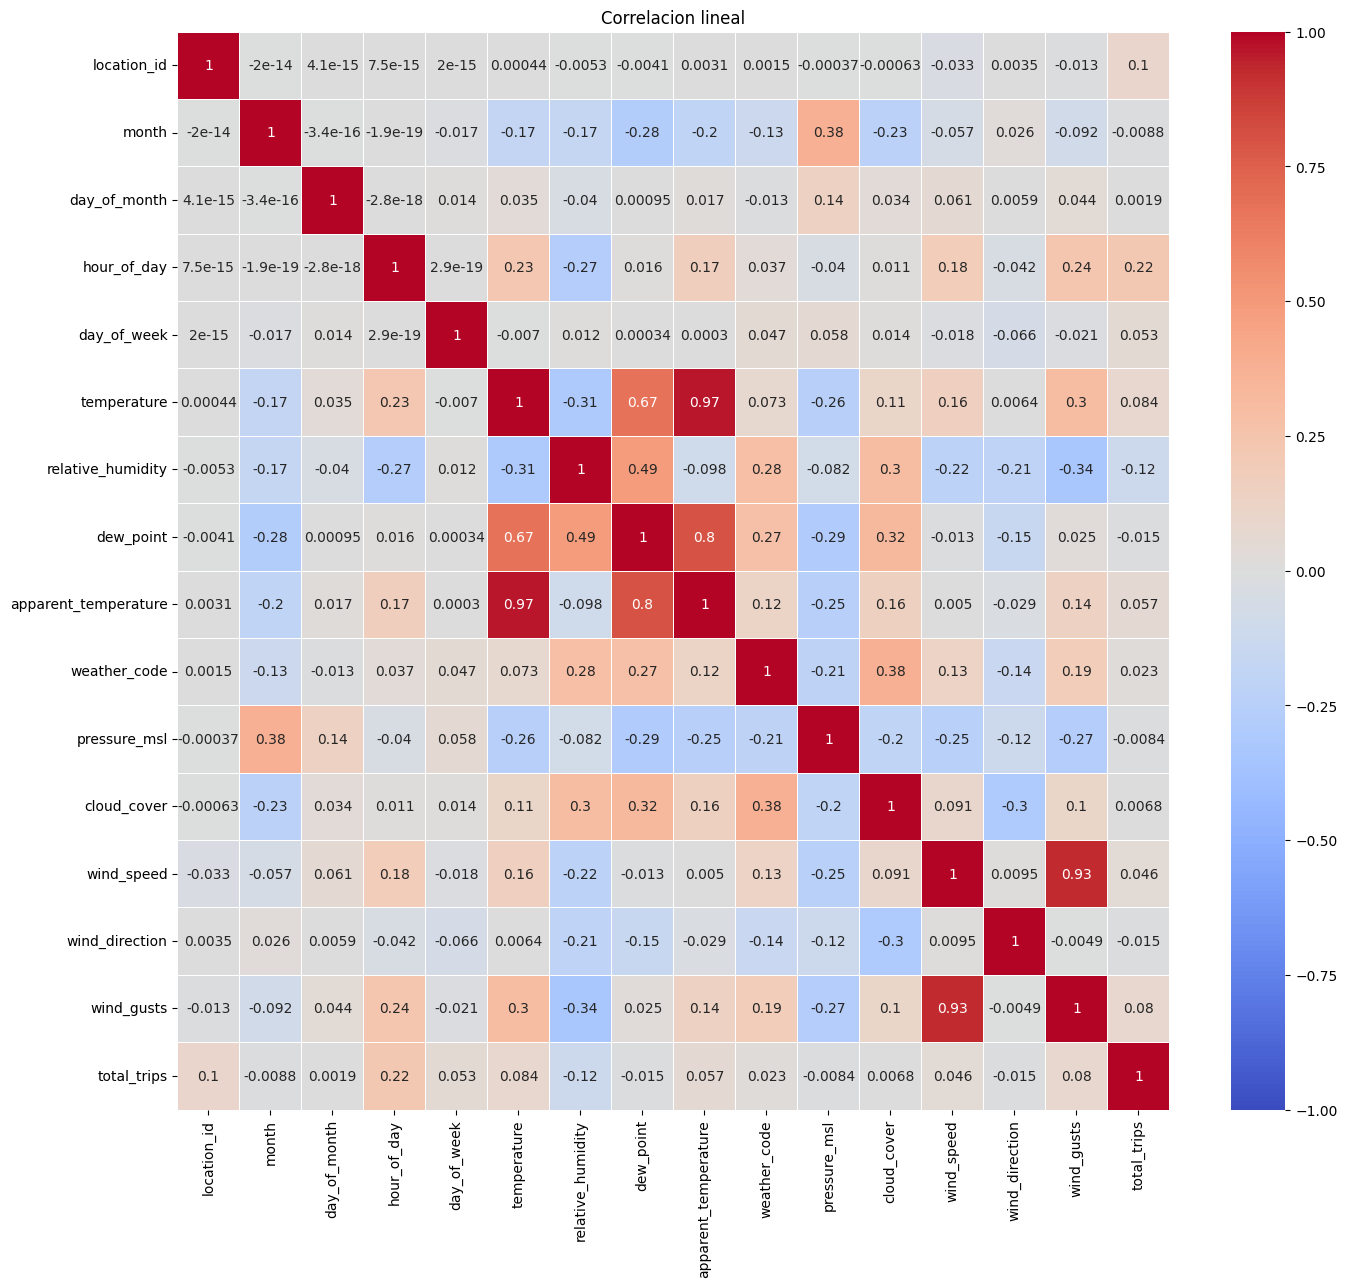

In [35]:
# Usando ML_merge que los separa por locationID y ademas considera los valores 0

weather_location_corr = ML_merge[['location_id', 'month',
       'day_of_month', 'hour_of_day', 'day_of_week', 'temperature',
       'relative_humidity', 'dew_point', 'apparent_temperature',
       'weather_code', 'pressure_msl', 'cloud_cover', 'wind_speed',
       'wind_direction', 'wind_gusts', 'total_trips']].corr(method='pearson')

plt.figure(figsize=(16,14))
sns.heatmap(weather_location_corr, annot=True, linewidth=.5, cmap='coolwarm', vmin=-1)
plt.title('Correlacion lineal')
plt.xticks(rotation=90)
plt.show()

## En el mapa de correlaciones anterior se observan aquellas columnas (algunas esperadas) que están fuertemente correlacionadas, y por ende, sería redundante agregarlas todas al modelo ML.

# Paso 3: Sugerencias finales

## Del mapa de correlaciones anterior podemos extraer las siguientes observaciones y sugerencias:<br><br>Fuerte correlacion entre 'temperature', 'dew_point' y 'apparent_temperature', junto con una correlación debil con 'month', donde se recomienda quedarse con 'temperature'.<br><br>Una moderada correlacion entre 'relative_humidity', 'weather_code', 'cloud_cover' y 'pressure_msl'. Se recomienda quedarse con 'weather_code'.<br><br>Otra moderada correlacion entre 'wind_speed' y 'wind_gusts'. Aquí se consideraría 'wind_speed'.<br><br>Tambíen se recomienda descartar año, ya que la muestra tiene 2024 y la data solo cubre 2 valores, ninguno de los cuales forma parte de la predicción, y el mes porque hay una moderada correlacion con 'weather_code', y en el análisis no se observó una tendencia con el mes, mas allá del efecto del numero de días en el total de viajes.

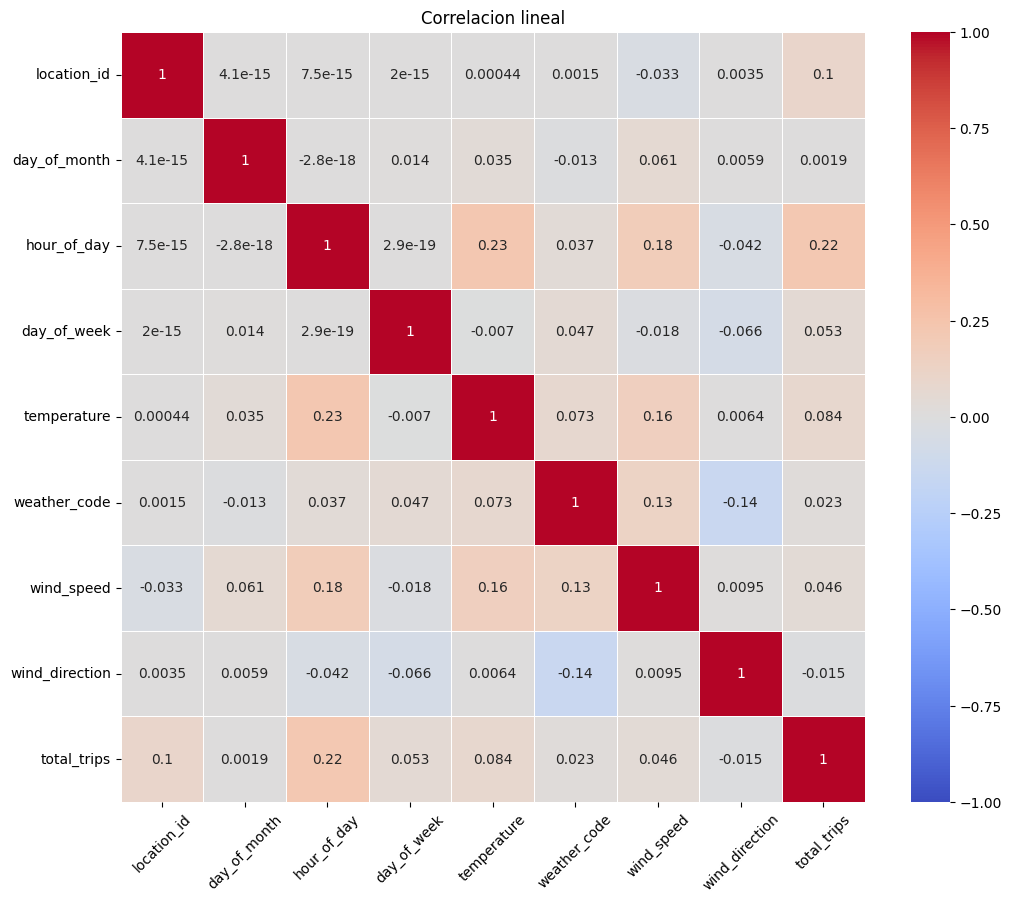

In [36]:
weather_location_corr = ML_merge[['location_id',
       'day_of_month', 'hour_of_day', 'day_of_week', 'temperature',
        'weather_code', 'wind_speed',
       'wind_direction', 'total_trips']].corr(method='pearson')

plt.figure(figsize=(12,10))
sns.heatmap(weather_location_corr, annot=True, linewidth=.5, cmap='coolwarm', vmin=-1)
plt.title('Correlacion lineal')
plt.xticks(rotation=45)
plt.show()

## Luego de remover las columnas que estaban correlacionadas y aquellas que por análisis debían ser descartadas, obtenemos el siguiente mapa de calor de correlaciones, que se sugiere utilizar como punto de partida para el entrenamiento y optimización del producto ML.

# Entrenamiento con todos los atributos

Mejores hiperparámetros: {'eta': 0.1, 'max_depth': 15, 'n_estimators': 200, 'random_state': 42, 'subsample': 1}
Mejor Score: 0.95033700466156

Mean Squared Error (MSE): 1031.9054956307061
Mean Absolute Error (MAE): 15.440409299015855
R² Score: 0.9578356742858887
Importancia de las Características:
location_id       0.564484
hour_of_day       0.240707
day_of_week       0.139453
temperature       0.013431
weather_code      0.012884
wind_direction    0.010191
day_of_month      0.009681
wind_speed        0.009169
dtype: float32


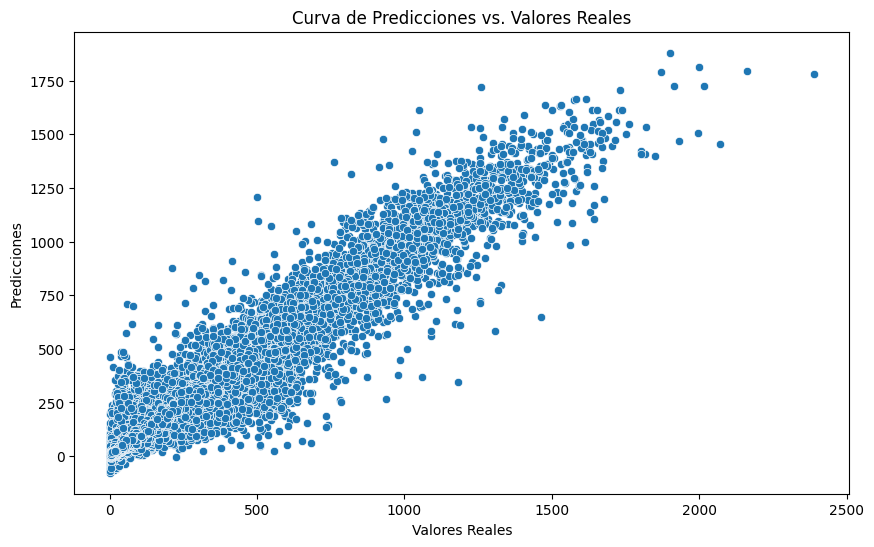

In [37]:
# Variables predictoras (X) y variable objetivo (y)
predictors = ['location_id',
       'day_of_month', 'hour_of_day', 'day_of_week',
              'temperature',
              'weather_code',
              'wind_speed', 'wind_direction']
X = ML_merge[predictors]
y = ML_merge['total_trips']

# Dividir los datos en conjunto de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------- PRUEBA GRIDSEARCH-----------------#
param_grid = {'n_estimators':[100, 200],
              'max_depth': [15],
              'eta':[0.05,0.1],
              'subsample':[1],
              'random_state':[42]}
xgb_model =xgb.XGBRegressor()
    # Probamos la estrategia grid search

model = GridSearchCV(xgb_model, param_grid=param_grid, cv=5)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# ------------- Busqueda Gridsearch----------------#
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

# Predecir con los datos de prueba
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Importancia de las características
# como esta dentro del GridSearch, se obtiene de esta forma
model = model.best_estimator_
importancia_caracteristicas = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
print("Importancia de las Características:")
print(importancia_caracteristicas)

# Visualización de la curva de predicciones vs. valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Curva de Predicciones vs. Valores Reales")
plt.show()


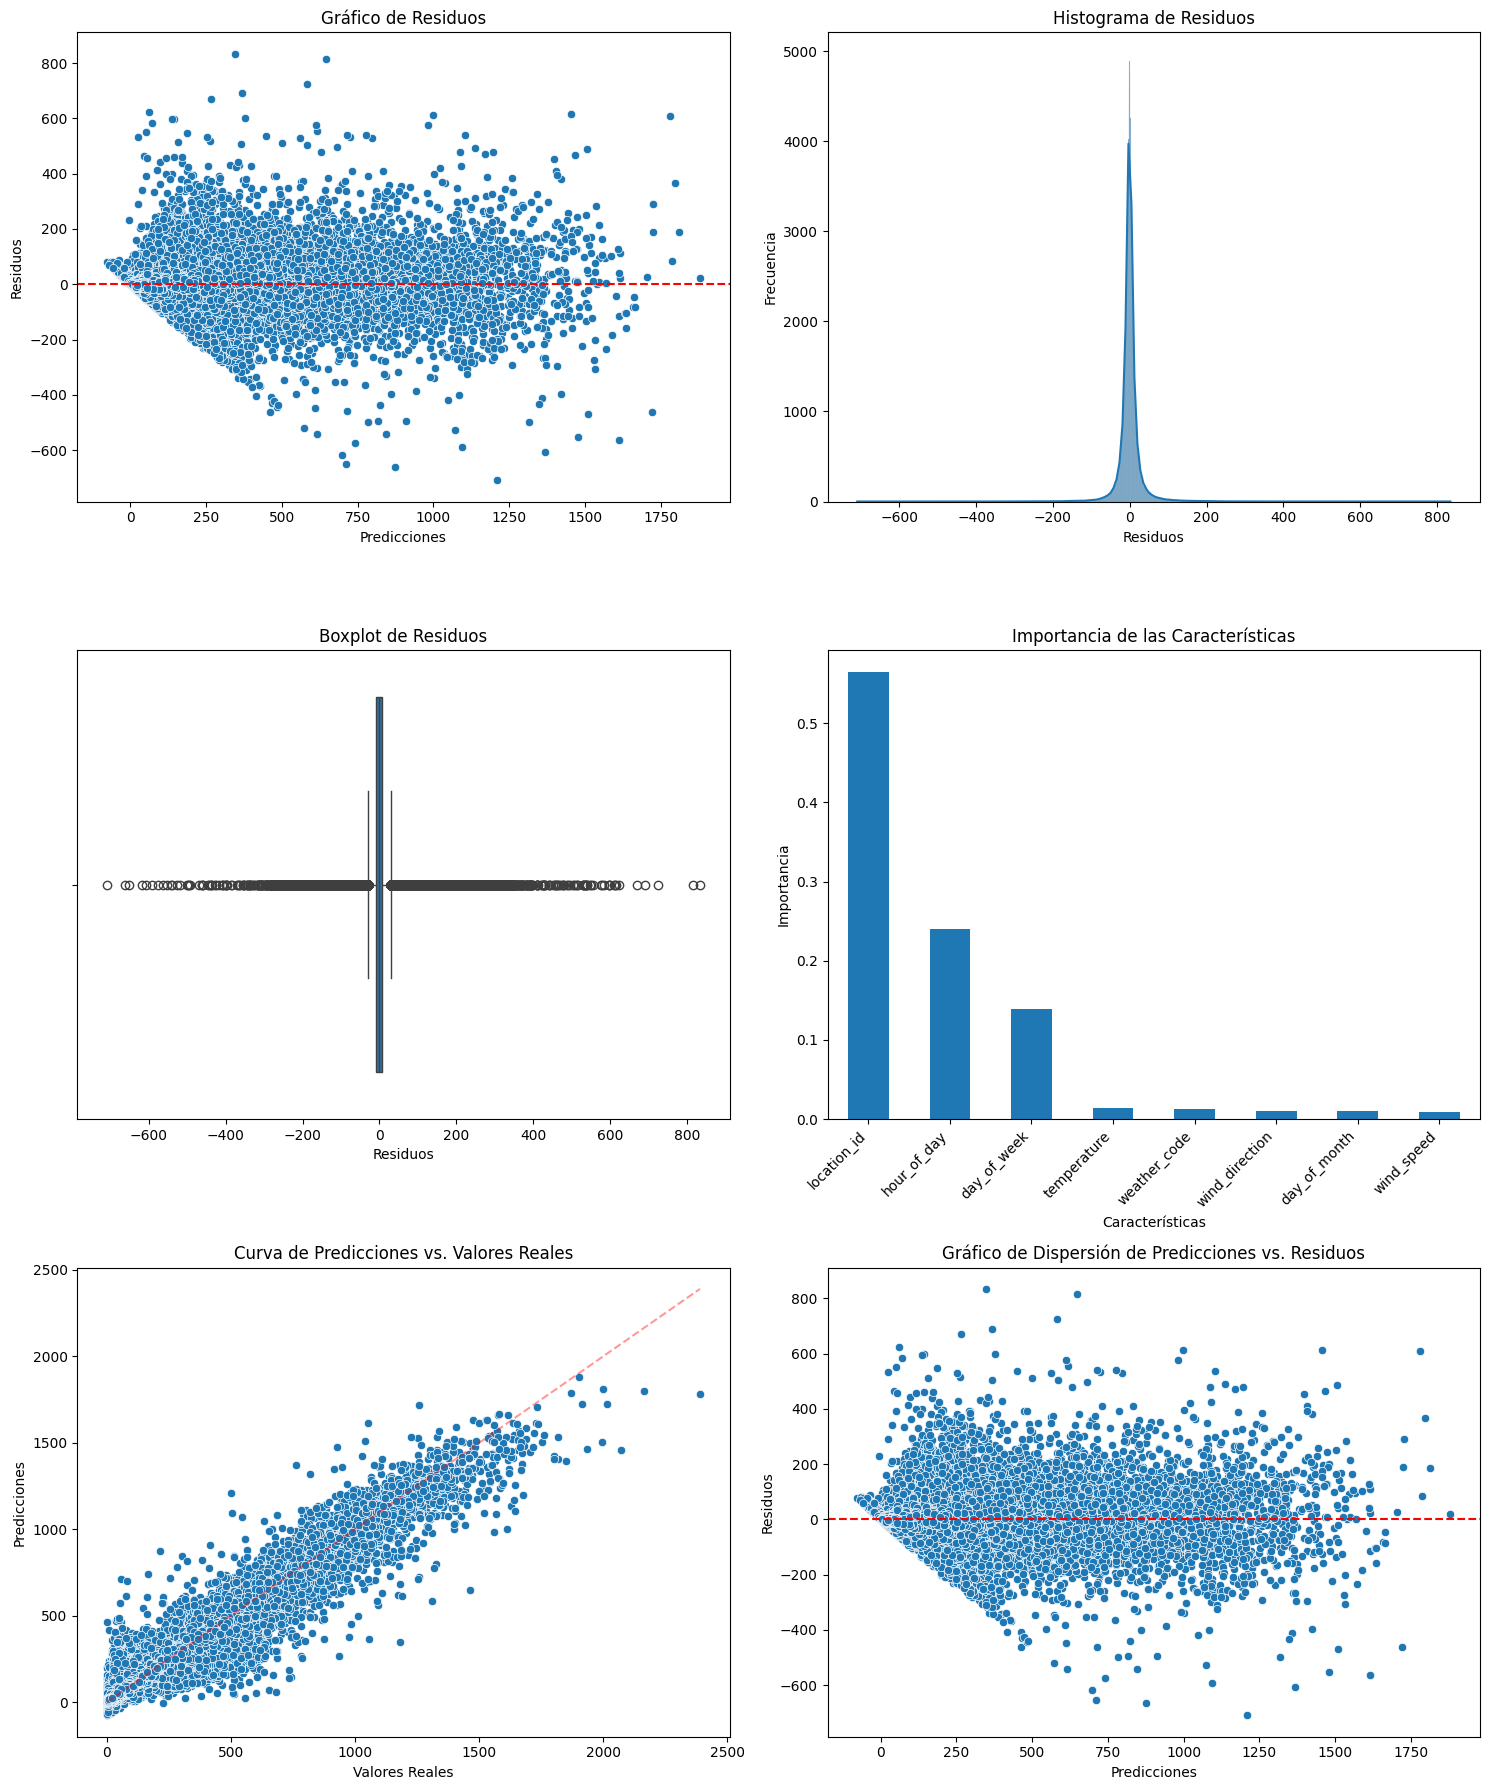

In [38]:
residuals = y_test - y_pred

# Crear subgráficos
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Gráfico de Residuos
sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, 0])
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Gráfico de Residuos")
axes[0, 0].set_xlabel("Predicciones")
axes[0, 0].set_ylabel("Residuos")

# Histograma de Residuos
sns.histplot(residuals, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Histograma de Residuos")
axes[0, 1].set_xlabel("Residuos")
axes[0, 1].set_ylabel("Frecuencia")

# Gráfico de Dispersión Predicción vs. Valores Reales
sns.scatterplot(x=y_test, y=y_pred, ax=axes[2, 0])
axes[2, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', alpha=0.4)
axes[2, 0].set_title("Curva de Predicciones vs. Valores Reales")
axes[2, 0].set_xlabel("Valores Reales")
axes[2, 0].set_ylabel("Predicciones")

# Crear el boxplot de los residuos
sns.boxplot(x=residuals,ax=axes[1, 0])
axes[1, 0].set_title("Boxplot de Residuos")
axes[1, 0].set_xlabel("Residuos")

# Gráfico de Importancia de Características
importancia_caracteristicas = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
importancia_caracteristicas.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_title("Importancia de las Características")
axes[1, 1].set_xlabel("Características")
axes[1, 1].set_ylabel("Importancia")

# Gráfico de Dispersión Predicción vs. Residuos
sns.scatterplot(x=y_pred, y=residuals, ax=axes[2, 1])
axes[2, 1].axhline(0, color='r', linestyle='--')
axes[2, 1].set_title("Gráfico de Dispersión de Predicciones vs. Residuos")
axes[2, 1].set_xlabel("Predicciones")
axes[2, 1].set_ylabel("Residuos")

# Ajustar el diseño
plt.tight_layout()
plt.show()

# De la anterior grilla de graficos podemos observar el comportamiento del mejor modelo de acuerdo al proceso GridSearch, donde podemos ver que tenemos un valor de R cuadrado de 0.9503 y que las columnas que mayor peso tienen a la hora de realizar las predicciones son, como se observó en análisis previos, ademas del location_id, la hora del dia y el día de la semana.

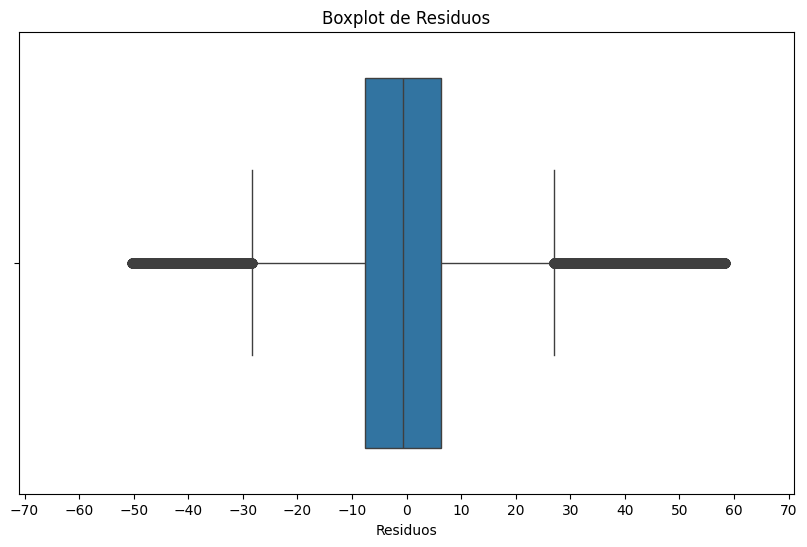

In [39]:
# Crear el boxplot del 95% central de los residuos
plt.figure(figsize=(10, 6))
sns.boxplot(x=residuals[(residuals>=residuals.quantile(0.025))&(residuals<=residuals.quantile(0.975))])
plt.title("Boxplot de Residuos")
plt.xlabel("Residuos")
plt.xlim(-71,71)
plt.xticks(np.arange(-70,71,step=10))
plt.show()

# En el boxplot anterior podemos observar el 95% central de los residuos, que se encuentran en su mayoría en un rango de error de aproximadamente $\pm$ 30 viajes por hora por location_id.

# Para concluir, de este análisis se tiene que los hiperparámetros recomendados para realizar el entrenamiendo del modelo ML son:
## Hiperparámetros: {'eta': 0.1, 'max_depth': 15, 'n_estimators': 200, 'random_state': 42, 'subsample': 1}